**MathTools HW3** 
2024-10-21

Question 3

In [1685]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import scipy.io

In [1686]:
data = scipy.io.loadmat('hrfDeconv.mat')
r = data.get('r').flatten()
x = data.get('x').flatten()

time = range(len(x))
r_new = r[:len(x)]

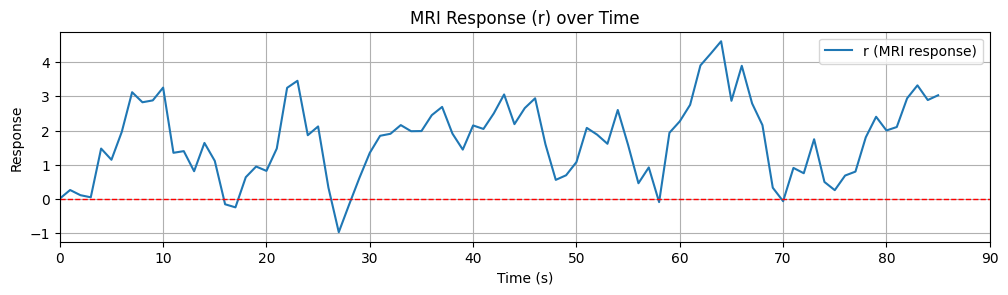

In [1687]:
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(time, r_new, label='r (MRI response)')
plt.axhline(y=0, color='red', linestyle='--', linewidth=1)
plt.xlim(0, 90)
plt.title('MRI Response (r) over Time')
plt.xlabel('Time (s)')
plt.ylabel('Response')
plt.legend()
plt.grid(True)

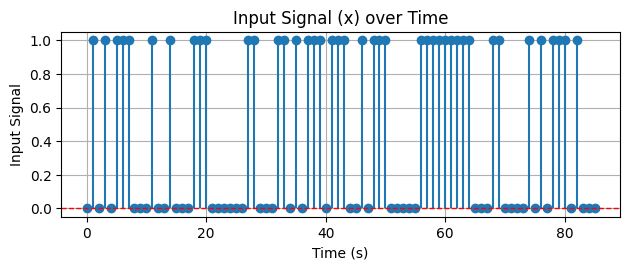

In [1688]:
plt.subplot(2, 1, 2)
plt.stem(time, x, basefmt=" ")
plt.axhline(y=0, color='red', linestyle='--', linewidth=1)
plt.title('Input Signal (x) over Time')
plt.xlabel('Time (s)')
plt.ylabel('Input Signal')
plt.grid(True)

plt.tight_layout()
plt.show()

(a)

In [1689]:
# Define the function, create a convolution matrix X for an input vector x and filter length M.
def createConvMat(x, M):
    N = len(x)
    
    # Empty place holder
    X = np.zeros((N + M - 1, M))

    for i in range(M):
        X[i:i+N, i] = x

    return X

In [1690]:
# Testing the convolution matrix
#x = np.random.rand(50)
M = 15
X = createConvMat(x , M)

In [1691]:
# Testing with random h vector
h = np.random.rand(M)

# Manually calculated convolution
N_holder = len(X)
r_calculated = [0] * N_holder
for i in range(N_holder):
    for j in range(M):
        r_calculated[i] += X[i][j] * h[j]
# Python built in matrix multiplication operator: @; np.dot(); np.matmul()
#r_calculated = X @ h

r_python = np.convolve(x, h, mode='full')  #python numpy built in convolution


In [1692]:
print("Check if the two responses are almost equal:", np.allclose(r_calculated, r_python))

Check if the two responses are almost equal: True


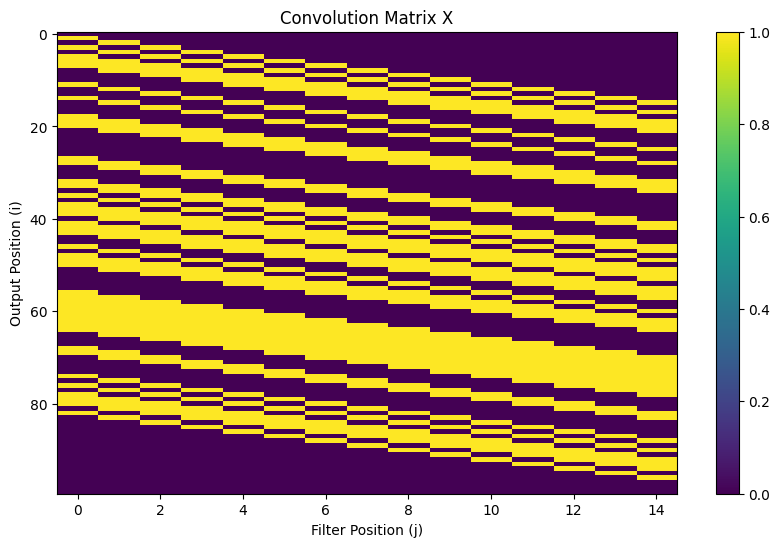

In [1693]:
plt.figure(figsize=(10, 6))
plt.imshow(X, aspect='auto', cmap='viridis')
plt.colorbar()
plt.title('Convolution Matrix X')
plt.xlabel('Filter Position (j)')
plt.ylabel('Output Position (i)')
plt.show()

In this image, each row contains shifted values of the input vector 𝑥. This structure illustrates how the input signal (a series of impulses over time) is transformed to create the delayed MRI response 𝑟.


(b)

In [1694]:
# Manually calculating transpose
def transpose_matrix(matrix):
    rows = len(matrix)
    cols = len(matrix[0])
    transposed = [[0] * rows for _ in range(cols)] #since only cares about number of rows to create the same column
    for i in range(rows):
        for j in range(cols):
            transposed[j][i] = matrix[i][j]
    return transposed

In [1695]:
# Manually calculating matrices multiplication
def multiply_matrices(A, B):
    rows_A = len(A)
    cols_A = len(A[0])
    rows_B = len(B)
    cols_B = len(B[0])

    assert cols_A == rows_B, "Error"

    result = [[0] * cols_B for _ in range(rows_A)]
    for i in range(rows_A):
        for j in range(cols_B):
            for k in range(cols_A): #necessary, since k is accumulating the total sum of all elements in accordance
                result[i][j] += A[i][k] * B[k][j]    
    return result

In [1696]:
# Manually calculating inverse matrix
def inverse_matrix(matrix):
    n = len(matrix)                     
    identity_matrix = [[float(i == j) for i in range(n)] for j in range(n)] #float is for deciding whether it's a diagonal element based on the output, 1 for yes and 0 for no; and using inner layer and outer layer to avoid too many for loops
    copy = [matrix[i] + identity_matrix[i] for i in range(n)]

    #Gauss-Jordan elimination
    for i in range(n):
        coef = copy[i][i]
        for j in range(2 * n):
            copy[i][j] /= coef
        
        for k in range(n):
            if k != i:
                coef = copy[k][i]
                for j in range(2 * n):
                    copy[k][j] -= coef * copy[i][j]

    inverse = [row[n:] for row in copy]
    return inverse

In [1697]:
# Manually multiplying a matrix with a vector
def multiply_matrix_vector(matrix, vector):
    rows = len(matrix)
    cols = len(matrix[0])

    assert cols == len(vector), "Error"

    result = [0] * rows
    for i in range(rows):
        for j in range(cols):
            result[i] += matrix[i][j] * vector[j]
    return result

In [1698]:
# Solving the least-squares regression problem MANUALLY
def leastSquares_calculated(X, r):

    #Step 1: X-transpose
    X_transpose = transpose_matrix(X)

    #Step 2: matrices mutiplications of X-transpose and X
    XT_X = multiply_matrices(X_transpose, X)

    #Step 3: MANUALLY CALCULATING INVERSE IN PYTHON (which is the cruelest thing that I've ever been through) of step 2
    XT_X_inv = inverse_matrix(XT_X)

    # Step 4: X-transpose * r
    XT_r = multiply_matrix_vector(X_transpose, r)

    # Step 5: h_opt = (X^T * X)^-1 * (X^T * r)
    h_opt_calculated_test = multiply_matrix_vector(XT_X_inv, XT_r)
    
    return h_opt_calculated_test


In [1699]:
# svd to calculate least square, manually
U, Sigma, VT = np.linalg.svd(X, full_matrices=False)
Sigma_pinv = np.diag(1 / Sigma)

#r = r[:len(X)].reshape(-1, 1)
h_opt_calculated = VT.T @ Sigma_pinv @ U.T @ r


In [1700]:
h_opt_calculated_test = leastSquares_calculated(X, r_calculated)
print("Check if two ways of calculating least square are equal:", np.allclose(h_opt_calculated, h_opt_calculated_test))

Check if two ways of calculating least square are equal: False


In [1701]:
## Sanity check sections ##
# Solving the least-squares regression problem with all build in functions
def leastSquares_python(X, r):
    X_transpose_python = np.transpose(X)
    h_opt_python = np.linalg.inv(X_transpose_python @ X) @ (X_transpose_python @ r)
    return h_opt_python

In [1702]:
#h_opt_calculated = leastSquares_calculated(X, r_calculated)
h_opt_python = leastSquares_python(X, r)
h_opt_calculated = h_opt_calculated.flatten()

In [1703]:
print("Check if the two responses are almost equal:", np.allclose(h_opt_calculated, h_opt_python))

Check if the two responses are almost equal: True


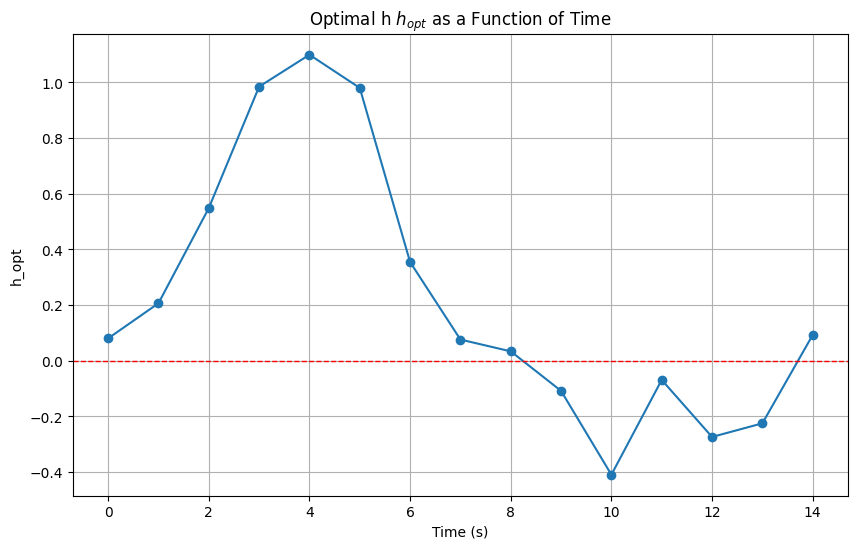

In [1704]:
#Plotting
time_h = np.arange(len(h_opt_calculated))

plt.figure(figsize=(10, 6))
plt.plot(time_h, h_opt_calculated, marker='o')
plt.axhline(y=0, color='red', linestyle='--', linewidth=1)
plt.title("Optimal h $h_{opt}$ as a Function of Time")
plt.xlabel("Time (s)")
plt.ylabel("h_opt")
plt.grid(True)
plt.show()

The plot of $h_{opt}$ as a function of time represents a temporal response of an impulse response. From the graph we can see that it's fluctuating. 
And it's lating for 14s. 

(c)

In [1705]:
# FFT to HRF
h_opt_calculated = np.array(h_opt_calculated)
H = np.fft.fft(h_opt_calculated)

In [1706]:
# Get the power spectrum
power_spectrum = np.abs(H) ** 2
# Shiifting the zero-value to center
power_spectrum_shifted = np.fft.fftshift(power_spectrum)

In [1707]:
# Get the frequency
nn = len(h_opt_calculated)
freuency = np.fft.fftfreq(nn) #sampling rate is at 1hz
freq_shifted = np.fft.fftshift(freuency)

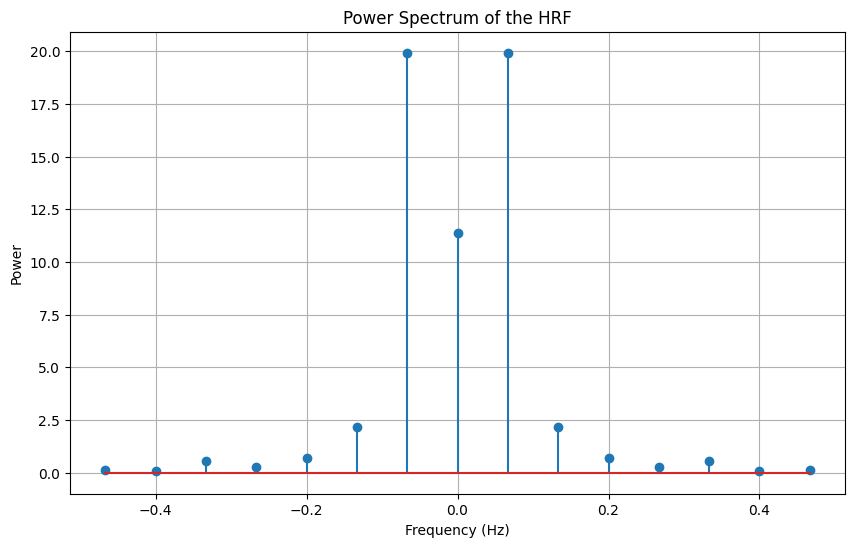

In [1708]:
plt.figure(figsize=(10, 6))
plt.stem(freq_shifted, power_spectrum_shifted)
plt.title('Power Spectrum of the HRF')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power')
plt.grid(True)
plt.show()

Based on th plot, we can tell that the HRF is a low-pass filter, allowing low frequencies (including the DC component) to pass through. I think it make sense, since HRD is corresponding to slow and sustained changes, such as blood flow changes in response to neural activities. 

(d)

In [1709]:
# Convolution theorem in fourier domain
# The Convolution Theorem states that the convolution of two signals in the time domain is equivalent to multiplying their Fourier transforms in the frequency domain. 
r_questiond = np.array(r_calculated)
maxlength = max(len(x), len(r_questiond)) 
x_pad = np.pad(x, (0, maxlength - len(x)), 'constant')
r_pad = np.pad(r, (0, maxlength - len(X)), 'constant')

x_fft = np.fft.fft(x_pad)
r_questiond_fft = np.fft.fft(r_pad)

In [1710]:
# Calculate the fourier transform of $h_{opt}$ in fourier domain
h_questiond_fft = r_questiond_fft / x_fft

# In time domain
h_questiond_fft_recovered = np.fft.ifft(h_questiond_fft)[:M].real 


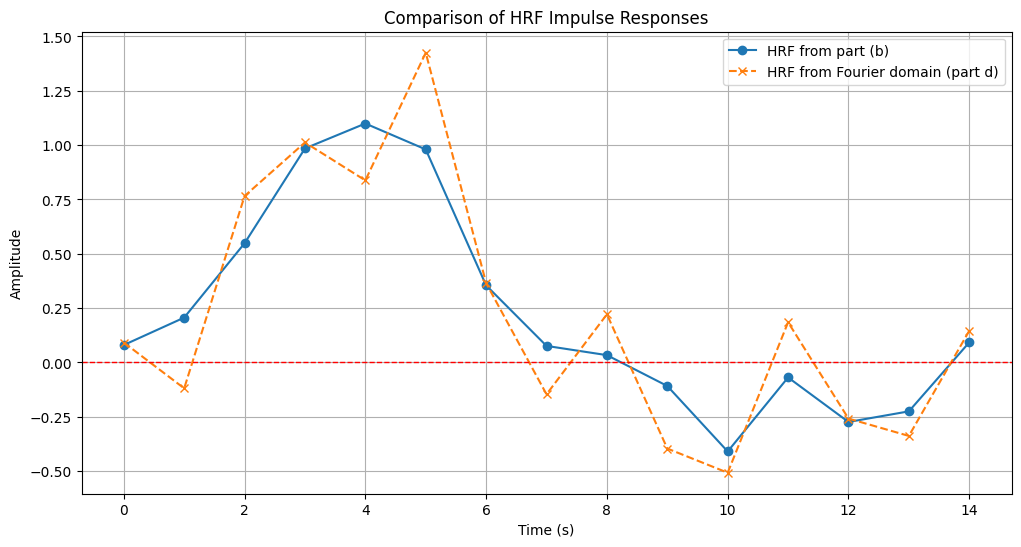

In [1712]:
#Plotting (b) and (d)
time_questiond = np.arange(len(h_questiond_fft_recovered))

plt.figure(figsize=(12, 6))
plt.plot(time_questiond, h_opt_calculated, '-o', label='HRF from part (b)')
plt.plot(time_questiond, h_questiond_fft_recovered, '--x', label='HRF from Fourier domain (part d)')
plt.axhline(y=0, color='red', linestyle='--', linewidth=1)
plt.title('Comparison of HRF Impulse Responses')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)
plt.show()

From the graph, after zero-padding, I can tell that the Convolution theorem in fourier domain is providing a only-okay approximation of the HRF, providing a similar tendency.

However, this method would fail if the input signal x has zero values at any frequency. Or, if the input and response signal have too high noise level, which will get amplified during the division step. 